# Imports

In [405]:
# Visualization
from qiskit.visualization import array_to_latex
from qiskit.visualization import plot_histogram

# BackEnd
from qiskit.providers.basic_provider import BasicProvider

# Circuit
from qiskit import QuantumRegister, QuantumCircuit, transpile, assemble
from qiskit.circuit.library import CCZGate, ZGate

# Criação do Oráculo que representa a nossa expressão

In [406]:
def GetOracle():
  from qiskit.circuit.library import PhaseOracle
  expression = "(~A | ~B | ~C) & (A | ~B | C) & (A | B | ~C) & (A | ~B | ~C) & (~A | B | C)"
  oracle = PhaseOracle(expression)
  return oracle

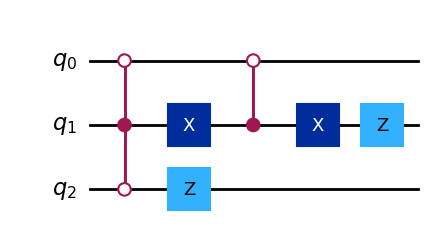

In [407]:
oracle = GetOracle()
oracle.draw("mpl")

# Zero Reflection

In [408]:
def GetZeroReflection(oracle):
  num_qubits = 3
  qubits = [0, 1, 2]
  qr_state = QuantumRegister(num_qubits, "state")
  reflection = QuantumCircuit(qr_state)

  first_qubit = qubits[0]
  second_qubit = qubits[1]
  third_qubit = qubits[2]

  reflection.x(qubits)
  reflection.h(qubits[third_qubit])
  reflection.mcx([0,1], qubits[third_qubit])
  reflection.h(qubits[third_qubit])
  reflection.x(qubits)

  return reflection

In [409]:
print(GetZeroReflection(oracle))

         ┌───┐          ┌───┐     
state_0: ┤ X ├───────■──┤ X ├─────
         ├───┤       │  ├───┤     
state_1: ┤ X ├───────■──┤ X ├─────
         ├───┤┌───┐┌─┴─┐├───┤┌───┐
state_2: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├
         └───┘└───┘└───┘└───┘└───┘


# Concatenando oráculo com operador de grover
(Grover Operator + Oracle)

In [410]:
def ApplyGrover(oracle):
  num_qubits = 3
  qr = QuantumRegister(num_qubits, name="State")
  qc = QuantumCircuit(qr, name = "Grover Operator")
  qubits = [0, 1, 2]
  qc.compose(oracle, qubits, inplace=True)

  # Aplica Hadamart Para cada qubit
  for q in range(num_qubits):
    qc.h(q)
  # Aplica reflexão para 0
  qc.compose(
      GetZeroReflection(oracle), qubits, inplace=True
  )
  # Aplica Hadamart Para cada qubit
  for q in range(num_qubits):
    qc.h(q)

  return qc

In [411]:
# (~A | ~B | ~C) & (A | ~B | C) & (A | B | ~C) & (A | ~B | ~C) & (~A | B | C)
oracle = GetOracle()
merged_two = ApplyGrover(oracle)
merged_two.draw()

┌───┐┌───┐               ┌───┐┌───┐     
State_0: ─o────────o──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────
          │ ┌───┐  │  ├───┤├───┤┌───┐┌───┐  │  ├───┤├───┤     
State_1: ─■─┤ X ├──■──┤ X ├┤ Z ├┤ H ├┤ X ├──■──┤ X ├┤ H ├─────
          │ ├───┤┌───┐├───┤├───┤└───┘└───┘┌─┴─┐├───┤├───┤┌───┐
State_2: ─o─┤ Z ├┤ H ├┤ X ├┤ H ├──────────┤ X ├┤ H ├┤ X ├┤ H ├
            └───┘└───┘└───┘└───┘          └───┘└───┘└───┘└───┘

# Amplificação com hadamart
(Hadamart > Grover Operator)

In [412]:
def AmplifyWithHadamart(qc, oracle):
  qc.h(0)
  qc.h(1)
  qc.h(2)

  qc.compose(oracle, inplace=True)
  return qc

# Montagem do circuito

Hadamart -> Grover and Oracle -> Measure

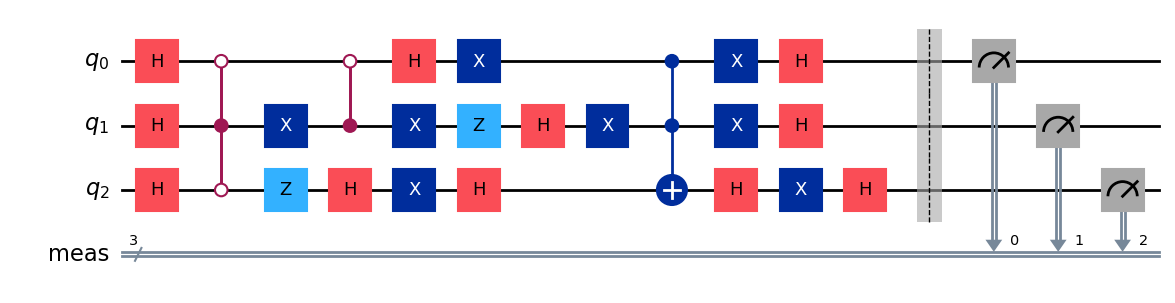

In [413]:
# Using Our Grover Operator
# (~A | ~B | ~C) & (A | ~B | C) & (A | B | ~C) & (A | ~B | ~C) & (~A | B | C)
three_sat = QuantumCircuit(3, name="Circuit for our 3-sat problem")

oracle = GetOracle()
groverCircuit = ApplyGrover(oracle)
AmplifyWithHadamart(three_sat, groverCircuit)

three_sat.measure_all()
three_sat.draw("mpl")

# Montagem do circuito usando o Qiskit para criar o oráculo (para fins de comparação)

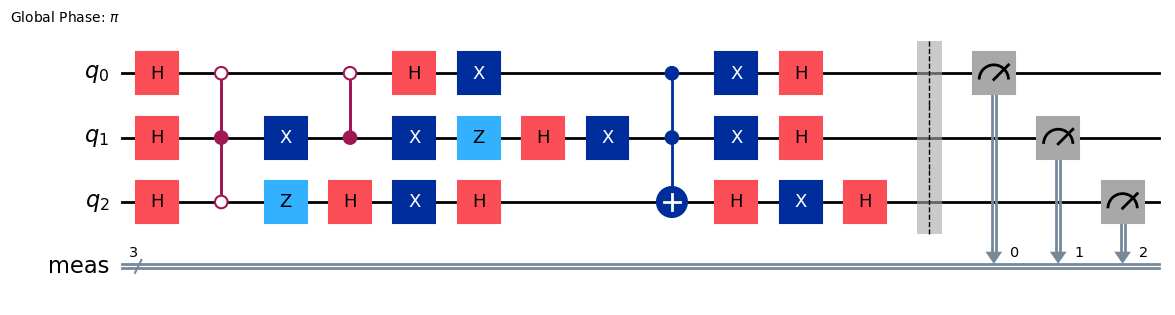

In [414]:
# Using IBM Grover
from qiskit.circuit.library import GroverOperator

three_sat_ibm = QuantumCircuit(3, name="Circuit for our 3-sat problem - IBM GROVER")
oracle = GetOracle()
groverCircuit = GroverOperator(oracle).decompose()
AmplifyWithHadamart(three_sat_ibm, groverCircuit)
three_sat_ibm.measure_all()
three_sat_ibm.draw("mpl")

# Execução do circuito

In [415]:
backend = BasicProvider().get_backend("basic_simulator")

# Execução do circuito - Nosso
transpiled = transpile(three_sat, backend)
qobj = assemble(transpiled)
result = backend.run(transpiled).result()
count = result.get_counts()

# Execução do circuito - IBM - GROVER
transpiled = transpile(three_sat_ibm, backend)
qobj = assemble(transpiled)
resultIBM = backend.run(transpiled).result()
countIBM = resultIBM.get_counts()

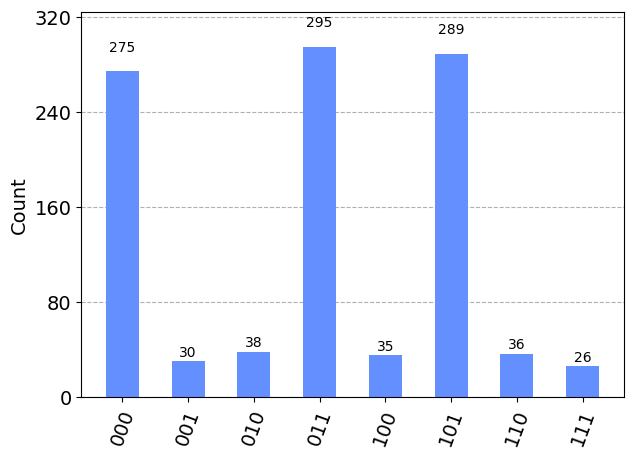

In [416]:
# Plot
plot_histogram(count)

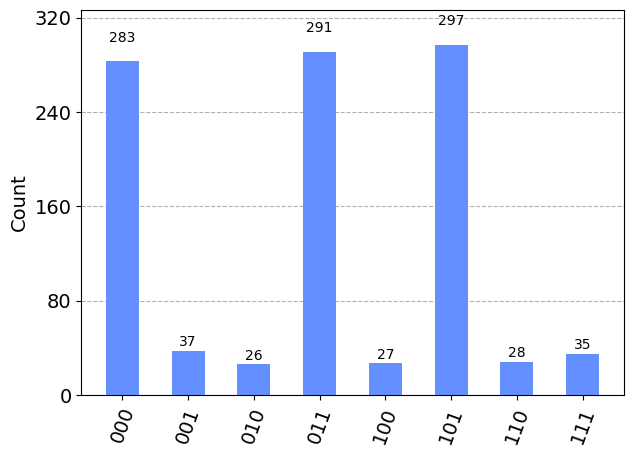

In [417]:
# Plot IBM
plot_histogram(countIBM)